In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Для анализа возьмем датасет с kaggle по поддержанным автомобилям. Ссылка на датасет - https://www.kaggle.com/datasets/shubham1kumar/usedcar-data

About Dataset
Based on various market surveys, the consulting firm has gathered a large dataset of different types of used cars across the market.

Data Dictionary:

Sales_ID (Sales ID)  
name (Марка автомобиля)  
year (Год приобретения)  
selling_price (Цена продажи)  
km_driven (Пробег в километрах)  
Region (Регион использования)  
State or Province (Штат)  
City (Город)  
fuel (Тип топлива)
seller_type (Кто продает)  
transmission (Коробка передач)  
owner (Количество владельцев)  
mileage (Максимальный заявленный производителем пробег в 10к миль)  
engine (Мощность двигателя)  
max_power (Максимальная мощность)  
seats (Количество мест)  
sold (Продана или нет)  

In [2]:
df = pd.read_csv('UserCarData.csv')
df.head()

,Sales_ID,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,sold
0,1,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,First_Owner,23.40,1248,74.00,190Nm@ 2000rpm,5,Y
1,2,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,Second_Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y
2,3,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,Third_Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y
3,4,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,First_Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y
4,5,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,First_Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y


## Шаг 1.

In [3]:
df = df.drop('Sales_ID', axis = 1)

In [4]:
print('Количество строк, столбцов - ',df.shape) #длина датасета
df.info()# смотрим общую информацию по колонкам, тут же проверяем наличие пустых ячеек

Количество строк, столбцов -  (7906, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7906 entries, 0 to 7905
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               7906 non-null   object 
 1   year               7906 non-null   int64  
 2   selling_price      7906 non-null   int64  
 3   km_driven          7906 non-null   int64  
 4   Region             7906 non-null   object 
 5   State or Province  7906 non-null   object 
 6   City               7906 non-null   object 
 7   fuel               7906 non-null   object 
 8   seller_type        7906 non-null   object 
 9   transmission       7906 non-null   object 
 10  owner              7906 non-null   object 
 11  mileage            7906 non-null   float64
 12  engine             7906 non-null   int64  
 13  max_power          7906 non-null   float64
 14  torque             7906 non-null   object 
 15  seats              7906 non-nul

In [5]:
df.drop_duplicates().shape #Проверка на дубликаты

(7884, 17)

In [6]:
df = df.drop_duplicates()#удаляем дубликаты, так как не влияют на общие показатели таблицы
df.shape

(7884, 17)

Посмотрим на сильные выбросы в столбцах цены

In [7]:
q1 = df.selling_price.quantile(0.25)
q3 = df.selling_price.quantile(0.75)
iqr = q3 - q1
print(q1,q3,iqr)

270000.0 690000.0 420000.0


In [8]:
df_out = df[(df.selling_price < (q1 - iqr*3))|(df.selling_price > (q3 + iqr*6))]#3й квантиль достаточно низкий для цены автомобиля, поэтому немного расширим диапозон
df_out.shape

(183, 17)

In [9]:
#Уберем строки, попадающие под наши выбросы
n_df = pd.concat([df,df_out]).drop_duplicates(keep = False)
n_df.shape

(7701, 17)

 Также посмотрим выбросы в пробеге

In [10]:
q1 = df.km_driven.quantile(0.25)
q3 = df.km_driven.quantile(0.75)
iqr = q3 - q1
print(q1,q3,iqr)
df_out = df[(df.km_driven < (q1 - iqr*3))|(df.km_driven > (q3 + iqr*3))]#3й квантиль достаточно низкий для цены автомобиля, поэтому немного расширим диапозон
df_out.shape

35000.0 96000.0 61000.0


(33, 17)

In [77]:
n_df = pd.concat([df,df_out]).drop_duplicates(keep = False)
n_df.shape

(7851, 17)

## Шаг 2

Создадим новые признаки на основе имеющихся колонок:  
  
1 - Посчитам срок эксплуатации автомобиля  
2 - Лимит пробега в километрах  
3 - Оставшийся пробег   
4 - Средний срок эксплуатации на одного владельца  
5 - Попробуем создать кофициэнт, показывающий качество автомобиля на основе положительных характеристик, поделенных на отрицательные  

In [12]:
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,sold
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,First_Owner,23.40,1248,74.00,190Nm@ 2000rpm,5,Y
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,Second_Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,Third_Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,First_Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,First_Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y


In [13]:
n_df['curr_expl_years'] = 2022 - n_df['year']
n_df['max_km'] = n_df['mileage'] * 1.60934 * 10000
n_df['kilometers_left'] = (n_df['max_km'] - n_df["km_driven"])
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,sold,curr_expl_years,max_km,kilometers_left
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,First_Owner,23.40,1248,74.00,190Nm@ 2000rpm,5,Y,8,376585.560,231085.560
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,Second_Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y,8,340214.476,220214.476
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,Third_Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y,16,284853.180,144853.180
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,First_Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y,12,370148.200,243148.200
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,First_Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y,15,259103.740,139103.740


Переведем столбец с числом владельцев в категориальный тип данных.
Также сделаем аналогичный стобец, но с числами, равными числу владельцев.  
Test_Drive_Car приравняем к First_Owner = 1

In [14]:
n_df.owner.unique()

array(['First_Owner', 'Second_Owner', 'Third_Owner', 'Fourth_Above_Owner',
       'Test_Drive_Car'], dtype=object)

In [15]:
n_df.owner = n_df.owner.astype('category').cat.reorder_categories(['First_Owner', 'Second_Owner', 'Third_Owner', 'Fourth_Above_Owner', 'Test_Drive_Car'], ordered = True)

In [16]:
n_df.owner.unique()

['First_Owner', 'Second_Owner', 'Third_Owner', 'Fourth_Above_Owner', 'Test_Drive_Car']
Categories (5, object): ['First_Owner' < 'Second_Owner' < 'Third_Owner' < 'Fourth_Above_Owner' < 'Test_Drive_Car']

In [17]:
def t_to_n(text):
    if text == 'First_Owner' : return 1
    elif text == 'Second_Owner' : return 2
    elif text == 'Third_Owner' : return 3
    elif text == 'Fourth_Above_Owner' : return 4
    elif text == 'Test_Drive_Car' : return 1

n_df['mean_num'] = n_df.owner.apply(t_to_n)
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,...,mileage,engine,max_power,torque,seats,sold,curr_expl_years,max_km,kilometers_left,mean_num
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,...,23.40,1248,74.00,190Nm@ 2000rpm,5,Y,8,376585.560,231085.560,1
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,...,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y,8,340214.476,220214.476,2
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,...,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y,16,284853.180,144853.180,3
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,...,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y,12,370148.200,243148.200,1
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,...,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y,15,259103.740,139103.740,1


In [18]:
n_df['mean_owner_time'] = round(n_df.curr_expl_years / n_df.mean_num, 2)
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,...,engine,max_power,torque,seats,sold,curr_expl_years,max_km,kilometers_left,mean_num,mean_owner_time
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,...,1248,74.00,190Nm@ 2000rpm,5,Y,8,376585.560,231085.560,1,8.00
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,...,1498,103.52,250Nm@ 1500-2500rpm,5,Y,8,340214.476,220214.476,2,4.00
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,...,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y,16,284853.180,144853.180,3,5.33
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,...,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y,12,370148.200,243148.200,1,12.00
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,...,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y,15,259103.740,139103.740,1,15.00


Для создания коэфициента: Положительное - значение, увеличение которых улучшает показатели автомобиля, отрицательные наоборот.  
Предположим, что чем дольше машина была у одного владельца, тем она скорее всего лучше.  
Для коэфициента покупок поделим еще и на текущую цену авто.

In [19]:
n_df['Coefficient'] = (n_df.engine * n_df.max_power * n_df.max_km * n_df.mean_owner_time * n_df.kilometers_left) /( n_df.km_driven * n_df.curr_expl_years*(10**10)) 
n_df['Sale_Coefficient'] = (n_df.engine * n_df.max_power * n_df.max_km * n_df.mean_owner_time * n_df.kilometers_left) / (n_df.km_driven * n_df.curr_expl_years * n_df.selling_price*(10**5))
n_df.shape

(7851, 24)

In [20]:
pd.set_option('display.max_columns', 24)#чтобы посмотреть 24 колонки сразу
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,sold,curr_expl_years,max_km,kilometers_left,mean_num,mean_owner_time,Coefficient,Sale_Coefficient
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,First_Owner,23.40,1248,74.00,190Nm@ 2000rpm,5,Y,8,376585.560,231085.560,1,8.00,5.523569,1.227460
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,Second_Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y,8,340214.476,220214.476,2,4.00,4.840871,1.308343
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,Third_Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y,16,284853.180,144853.180,3,5.33,1.146422,0.725584
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,First_Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y,12,370148.200,243148.200,1,12.00,8.903708,3.957204
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,First_Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y,15,259103.740,139103.740,1,15.00,3.438543,2.645033


## Шаг 3

In [21]:
n_df.mean_num.max() # Максимальное число владельцев авто

4

In [22]:
print(n_df['State or Province'].unique()) # Какие штаты находятся в таблице

['District of Columbia' 'New York' 'Illinois' 'California' 'Texas'
 'Massachusetts' 'Washington' 'Georgia' 'North Carolina' 'Florida'
 'Pennsylvania' 'Michigan' 'Iowa' 'Oregon' 'New Mexico' 'Maryland'
 'Montana' 'Arkansas' 'Arizona' 'Maine' 'Vermont' 'New Jersey'
 'Connecticut' 'Oklahoma' 'Tennessee' 'Alabama' 'Wisconsin'
 'South Carolina' 'New Hampshire' 'Idaho' 'Minnesota' 'Ohio' 'Kansas'
 'Utah' 'Virginia' 'Nebraska' 'West Virginia' 'Colorado' 'Indiana'
 'Kentucky' 'Missouri' 'North Dakota' 'Rhode Island' 'Louisiana' 'Wyoming'
 'Nevada' 'Mississippi' 'Delaware' 'South Dakota']


In [23]:
print(n_df['name'].mode()[0]) #Самое часто продаваемое авто
n_df['name'].value_counts(normalize=True)#Самые часто продаваемые авто в долях

Maruti


Maruti        0.300344
Hyundai       0.172589
Mahindra      0.095274
Tata          0.091071
Honda         0.058973
Toyota        0.055662
Ford          0.049293
Chevrolet     0.029296
Renault       0.028914
Volkswagen    0.023564
BMW           0.015030
Skoda         0.013247
Nissan        0.010317
Jaguar        0.008534
Volvo         0.008534
Datsun        0.008279
Mercedes      0.006878
Fiat          0.005222
Audi          0.005095
Lexus         0.004076
Jeep          0.003949
Mitsubishi    0.001656
Force         0.000764
Land          0.000764
Isuzu         0.000637
Kia           0.000509
Ambassador    0.000509
Daewoo        0.000382
MG            0.000382
Ashok         0.000127
Opel          0.000127
Name: name, dtype: float64

In [24]:
n_df.groupby(['transmission'])[['selling_price']].mean() # Средняя цена в зависимости от коробки передач

,selling_price
transmission,
Automatic,1.877688e+06
Manual,4.628051e+05


In [25]:
n_df.groupby(['name'])[['selling_price']].mean().sort_values(by = 'selling_price')

,selling_price
name,
Opel,6.800000e+04
Daewoo,7.700000e+04
Ambassador,1.240000e+05
Chevrolet,2.738675e+05
Ashok,3.000000e+05
Datsun,3.146000e+05
Fiat,3.171951e+05
Tata,3.613915e+05
Maruti,4.089421e+05


In [26]:
n_df.groupby(['year'])[['selling_price']].mean() # Чтобы посмотреть среднее увеличение цен в зависимости от года автомобиля

,selling_price
year,
1994,7.200000e+04
1995,5.500000e+04
1996,4.100000e+04
1997,8.611100e+04
1998,5.788889e+04
1999,7.692857e+04
2000,7.120814e+04
2001,4.650000e+04
2002,9.677778e+04


In [27]:
n_df.groupby(['year','mean_num'])[['selling_price' ]].mean().head(20) # смотрим зависимость изменения цен от количества владельцев

selling_price
year mean_num               
1994 1          45000.000000
     2          99000.000000
1995 1          55000.000000
1996 2          40000.000000
     3          42000.000000
1997 1          40000.000000
     2         104000.000000
     3          44999.500000
     4         125000.000000
1998 1          80000.000000
     2          54000.000000
     3          63000.000000
     4          45000.000000
1999 1          66000.000000
     2          87000.000000
     3          80000.000000
     4          63333.333333
2000 1          93000.000000
     2          54382.800000
     3          65000.000000

In [28]:
n_df.corr()#Построим корреляционную матрицу для нахождения зависимостей

,year,selling_price,km_driven,mileage,engine,max_power,seats,curr_expl_years,max_km,kilometers_left,mean_num,mean_owner_time,Coefficient,Sale_Coefficient
year,1.000000,0.412459,-0.512383,0.325915,0.024125,0.227139,-0.000627,-1.000000,0.325915,0.515876,-0.507933,-0.588194,0.014434,-0.004882
selling_price,0.412459,1.000000,-0.275965,-0.129529,0.458989,0.749873,0.045050,-0.412459,-0.129529,0.045426,-0.234806,-0.260595,0.027438,-0.005421
km_driven,-0.512383,-0.275965,1.000000,-0.184548,0.226747,-0.058340,0.253231,0.512383,-0.184548,-0.662809,0.346995,0.267063,-0.043783,-0.023375
mileage,0.325915,-0.129529,-0.184548,1.000000,-0.573357,-0.375612,-0.447249,-0.325915,1.000000,0.858247,-0.171329,-0.175904,-0.010521,-0.010094
engine,0.024125,0.458989,0.226747,-0.573357,1.000000,0.706473,0.608812,-0.024125,-0.573357,-0.555235,0.001382,-0.023409,0.001560,-0.007842
max_power,0.227139,0.749873,-0.058340,-0.375612,0.706473,1.000000,0.193404,-0.227139,-0.375612,-0.255704,-0.113797,-0.149705,0.014905,-0.006398
seats,-0.000627,0.045050,0.253231,-0.447249,0.608812,0.193404,1.000000,0.000627,-0.447249,-0.472987,0.025350,0.006051,-0.010584,-0.006822
curr_expl_years,-1.000000,-0.412459,0.512383,-0.325915,-0.024125,-0.227139,0.000627,1.000000,-0.325915,-0.515876,0.507933,0.588194,-0.014434,0.004882
max_km,0.325915,-0.129529,-0.184548,1.000000,-0.573357,-0.375612,-0.447249,-0.325915,1.000000,0.858247,-0.171329,-0.175904,-0.010521,-0.010094
kilometers_left,0.515876,0.045426,-0.662809,0.858247,-0.555235,-0.255704,-0.472987,-0.515876,0.858247,1.000000,-0.311734,-0.273479,0.014848,0.004516


Согласно матрице делаем вывод, что больше всего увеличиваеи цену авто влияет год выпуска, двигатель, максимальная мощность.  
Также сильные зависимости между годом выпуска и пробегом, оставшимся киллометражем, количеством владельцев.  
Также сильная зависимость между двигателем и заложенным в него пробегом, максимальной мощностью, количеством сидений (чем больше место тем больше нужно мощности).  
Также видим, что попытка вставить коэффициенты вышла не очень удачной, так как не коррелирует ни с какими показателями, соответственно опираться на них не стоит. Для правильного коэффициента нужно вместо умножения применять сложение величин с коэфициентами у каждой из них, что достаточно долгий процесс.

In [29]:
n_df.corr()[(n_df.corr() > 0.4) | (n_df.corr()< -0.4)] #чтобы явно увидеть высокие показатели

,year,selling_price,km_driven,mileage,engine,max_power,seats,curr_expl_years,max_km,kilometers_left,mean_num,mean_owner_time,Coefficient,Sale_Coefficient
year,1.000000,0.412459,-0.512383,NaN,NaN,NaN,NaN,-1.000000,NaN,0.515876,-0.507933,-0.588194,NaN,NaN
selling_price,0.412459,1.000000,NaN,NaN,0.458989,0.749873,NaN,-0.412459,NaN,NaN,NaN,NaN,NaN,NaN
km_driven,-0.512383,NaN,1.000000,NaN,NaN,NaN,NaN,0.512383,NaN,-0.662809,NaN,NaN,NaN,NaN
mileage,NaN,NaN,NaN,1.000000,-0.573357,NaN,-0.447249,NaN,1.000000,0.858247,NaN,NaN,NaN,NaN
engine,NaN,0.458989,NaN,-0.573357,1.000000,0.706473,0.608812,NaN,-0.573357,-0.555235,NaN,NaN,NaN,NaN
max_power,NaN,0.749873,NaN,NaN,0.706473,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seats,NaN,NaN,NaN,-0.447249,0.608812,NaN,1.000000,NaN,-0.447249,-0.472987,NaN,NaN,NaN,NaN
curr_expl_years,-1.000000,-0.412459,0.512383,NaN,NaN,NaN,NaN,1.000000,NaN,-0.515876,0.507933,0.588194,NaN,NaN
max_km,NaN,NaN,NaN,1.000000,-0.573357,NaN,-0.447249,NaN,1.000000,0.858247,NaN,NaN,NaN,NaN
kilometers_left,0.515876,NaN,-0.662809,0.858247,-0.555235,NaN,-0.472987,-0.515876,0.858247,1.000000,NaN,NaN,NaN,NaN


## Шаг 4
Построим графики:   
зависимости цены от марки машины  
количества машин по штатам  
Зависимости цены от пробега  
График по штатам со средней ценой и мощностью двигателя

In [30]:
n_df.head()

,name,year,selling_price,km_driven,Region,State or Province,City,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,sold,curr_expl_years,max_km,kilometers_left,mean_num,mean_owner_time,Coefficient,Sale_Coefficient
0,Maruti,2014,450000,145500,East,District of Columbia,Washington,Diesel,Individual,Manual,First_Owner,23.40,1248,74.00,190Nm@ 2000rpm,5,Y,8,376585.560,231085.560,1,8.00,5.523569,1.227460
1,Skoda,2014,370000,120000,East,New York,New York City,Diesel,Individual,Manual,Second_Owner,21.14,1498,103.52,250Nm@ 1500-2500rpm,5,Y,8,340214.476,220214.476,2,4.00,4.840871,1.308343
2,Honda,2006,158000,140000,Central,Illinois,Chicago,Petrol,Individual,Manual,Third_Owner,17.70,1497,78.00,"12.7@ 2,700(kgm@ rpm)",5,Y,16,284853.180,144853.180,3,5.33,1.146422,0.725584
3,Hyundai,2010,225000,127000,Central,Illinois,Chicago,Diesel,Individual,Manual,First_Owner,23.00,1396,90.00,22.4 kgm at 1750-2750rpm,5,Y,12,370148.200,243148.200,1,12.00,8.903708,3.957204
4,Maruti,2007,130000,120000,East,New York,New York City,Petrol,Individual,Manual,First_Owner,16.10,1298,88.20,"11.5@ 4,500(kgm@ rpm)",5,Y,15,259103.740,139103.740,1,15.00,3.438543,2.645033


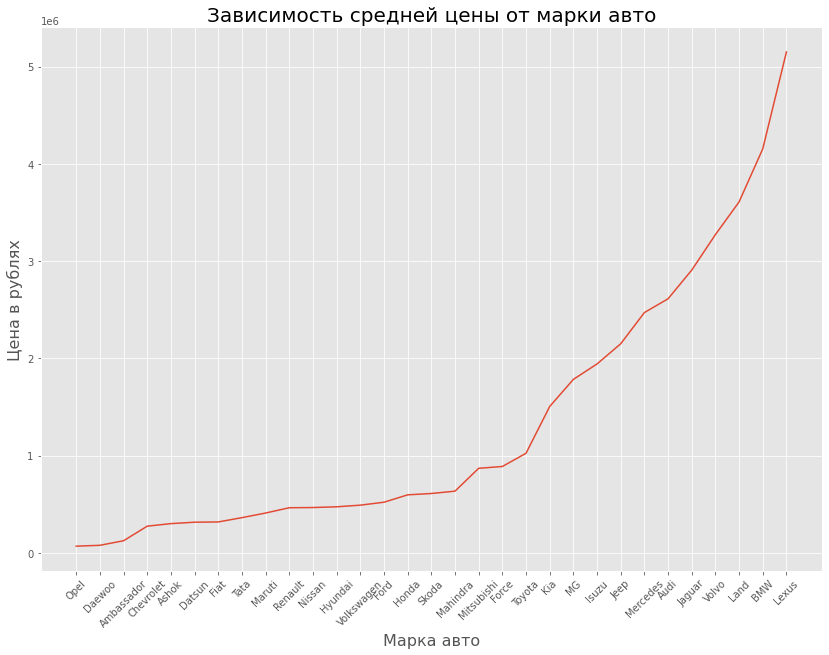

In [78]:
fig, ax = plt.subplots(figsize = (14,10))
ax1 = ax.plot(n_df.groupby('name')['selling_price'].mean().sort_values())
plt.title('Зависимость средней цены от марки авто', fontsize = 20)
ax.set_xlabel('Марка авто', fontsize = 16)
ax.set_ylabel('Цена в рублях', fontsize = 16)
plt.xticks(rotation = 45);

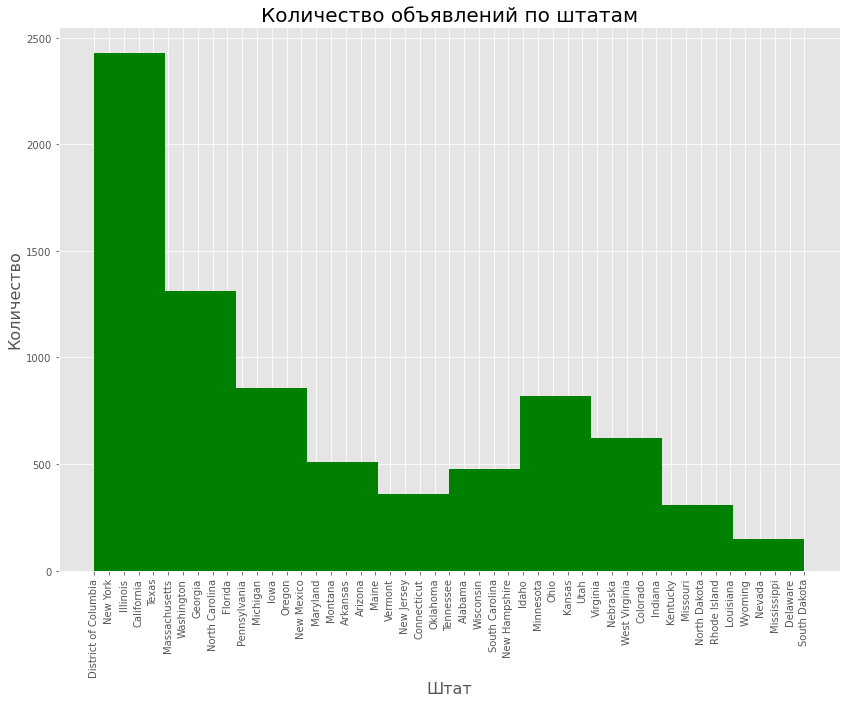

In [32]:
fig, ax = plt.subplots(figsize = (14,10))
ax1 = ax.hist(n_df['State or Province'], color = 'green')
plt.title('Количество объявлений по штатам', fontsize = 20)
ax.set_xlabel('Штат', fontsize = 16)
ax.set_ylabel('Количество', fontsize = 16)
plt.xticks(rotation = 90);

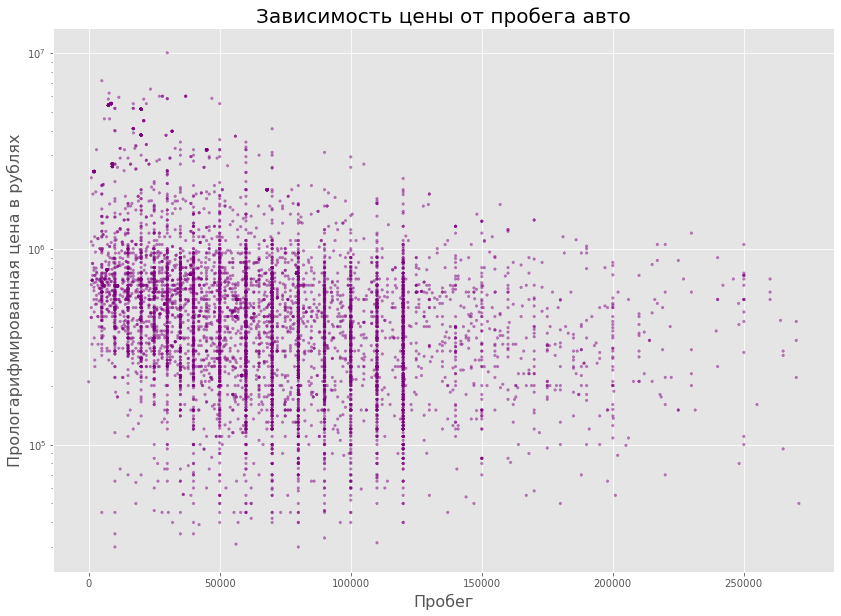

In [79]:
fig, ax = plt.subplots(figsize = (14,10))
ax1 = ax.scatter(n_df['km_driven'], n_df['selling_price'], color = 'purple', ls = ':', s = 8, alpha = 0.5)
plt.title('Зависимость цены от пробега авто', fontsize = 20)
plt.yscale('log')
ax.set_xlabel('Пробег', fontsize = 16)
ax.set_ylabel('Прологарифмированная цена в рублях', fontsize = 16);

C:\Users\BeezLy\AppData\Local\Temp\ipykernel_2488\3795436595.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(graph)


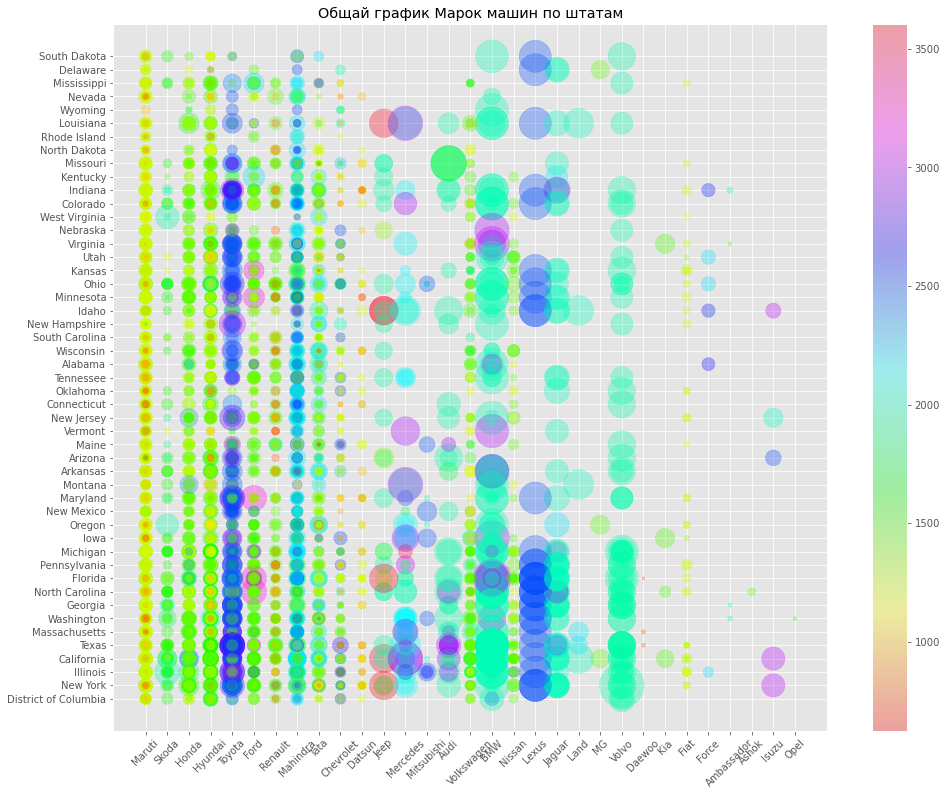

In [81]:
# График по штатам со средней ценой и мощностью двигателя
fig, ax = plt.subplots(figsize = (16,13))
graph = ax.scatter(n_df['name'], n_df['State or Province'],
                  s = n_df['selling_price']/5000, cmap = 'hsv', alpha = 0.3, c = n_df['engine'])
plt.colorbar(graph)
plt.title('Общай график Марок машин по штатам')
plt.xticks(rotation = 45);